# Test on human cancer cell lines scATAC dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")
import time 
from numpy import *
from scipy.sparse import *    
import anndata as ad
import pandas as pd
import scanpy as sc
from sklearn.cluster import KMeans,DBSCAN
import scBiMapping
from fast_ldp_mst_clustering import FastLDPMST

### Load test dataset

In [ ]:
adata = ad.read_h5ad('Human_Cancer_cell_lines_ATAC.h5ad')
print(adata)
nc = len(unique(adata.obs['cell_annotation']))
print('number of cell types: ' + str(nc))

AnnData object with n_obs × n_vars = 54075 × 606219
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score', 'cell_annotation', 'batch'
number of cell types: 39


## use all features

### Embedding

In [ ]:
%%time
n_embedding = 30
print('the embedding dimension: ' + str(n_embedding))
scBiMapping.scBiMapping_DR(adata,n_embedding = n_embedding)
print(adata)

the embedding dimension: 30
AnnData object with n_obs × n_vars = 54075 × 606219
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score', 'cell_annotation', 'batch'
    uns: 'V'
    obsm: 'U'
CPU times: user 17min 13s, sys: 1min 15s, total: 18min 29s
Wall time: 15min 54s


### Clustering (by either Kmeans, DBSCAN, or Leiden)

In [4]:
clustering_method_list = ['Kmeans','leiden','FastLDPMST']

### Clustering method 1: Kmeans

In [5]:
%%time
adata.obs['Kmeans'] = pd.Categorical(KMeans(nc,init = 'k-means++',n_init = 1).fit(adata.obsm['U']).labels_.astype('str'))

CPU times: user 2.95 s, sys: 10.9 s, total: 13.8 s
Wall time: 892 ms


### Clustering method 2: leiden

In [6]:
%%time
sc.pp.neighbors(adata,use_rep = 'U',n_neighbors = 30) 
sc.tl.leiden(adata,resolution = 0.7)

CPU times: user 1min 31s, sys: 2.01 s, total: 1min 33s
Wall time: 1min 31s


### Clusteirng method 3: FastLDPMST

In [7]:
%%time
N,Dim = adata.shape
K = int(ceil(log2(N))) - 5 
ratio = 0.01; # [0.01,0.02] is recommended; not needed for manual cutting; 
MinSize = ratio*N       
if Dim <= 10:
    knnMethod = 'KD-tree';
else:
    knnMethod = 'NNDescent'; # HNSW or NNDescent
labels,_,_ = FastLDPMST(adata.obsm['U'], nc, MinSize, K, knnMethod) 
adata.obs['FastLDPMST'] = pd.Categorical(labels.astype('str'))
print(f"number of clusters: {len(unique(adata.obs['FastLDPMST']))}")

find knn...
Search natural neighbors...
supk = 9
  Cut (stage 1): determine node weight in the constructed forest...
  cost time on 1st stage of Cut: 0.02291560173034668s
  Cut (stage 2): check the edges one by one in decreasing order of edge weight...
  time cost on the 2nd stage of Cut: 0.00036525726318359375s
number of clusters: 39
CPU times: user 1min 38s, sys: 31.4 s, total: 2min 9s
Wall time: 10.7 s


## Umap and Visualization

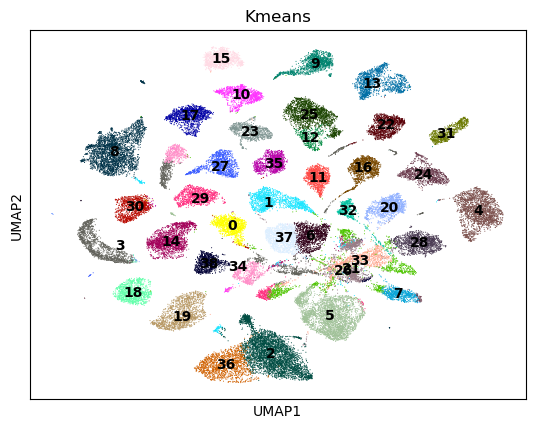

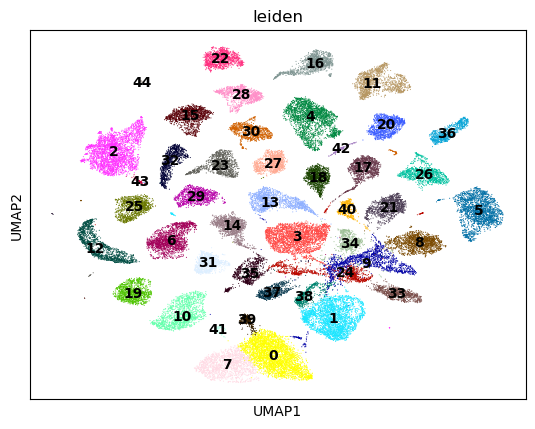

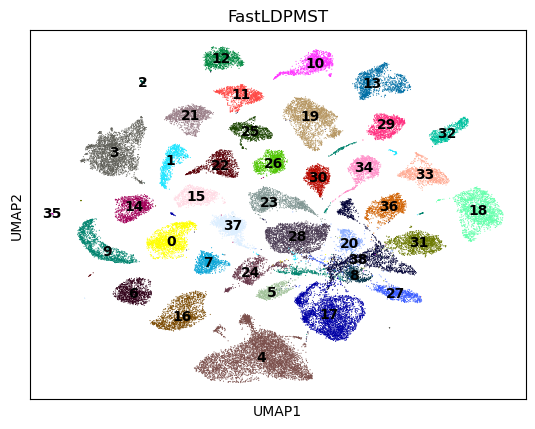

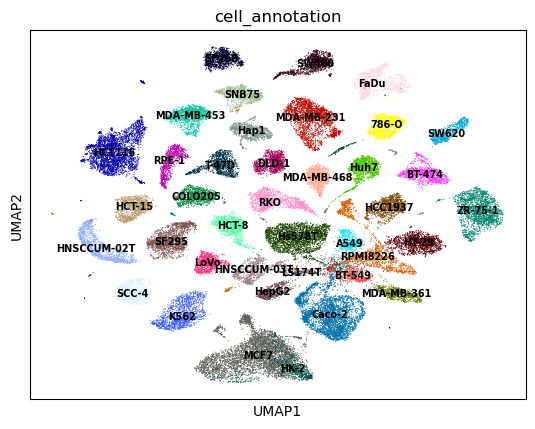

CPU times: user 26min 3s, sys: 125 ms, total: 26min 3s
Wall time: 2min 27s


In [8]:
%%time
sc.pp.neighbors(adata,use_rep = 'U',n_neighbors = 10) 
sc.tl.umap(adata, random_state=1)
for clustering_method in clustering_method_list:
    sc.pl.umap(adata, color=clustering_method,legend_loc='on data',legend_fontsize = 10)
sc.pl.umap(adata, color='cell_annotation',legend_loc='on data',legend_fontsize = 7)